In [1]:
#importing basic libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Importing pytorch functions and modules
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchtext import data
from sklearn.metrics import *

#Import NLP libraries
import re
import string
import nltk

#Setting random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

GeForce GTX 1050


### Functions for text processing

In [2]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|,;]^a-zA-Z#')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    
  
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
                    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
                    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                    "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", 
                    "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                    "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would",
                    "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
                    "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                    "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
                    "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
                    "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
                    "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                    "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                    "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", 
                    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# Usage
replace_contractions("this's a text with contraction")
    


def custom_tokenizer(text):
    """
        text: a string
        
        return: modified, pre-processed tokens
    """
#     text = # Remove long spaces and combine
#     text = # lowercase text
#     text = # replace REPLACE_BY_SPACE_RE symbols by space in text
#     text = # delete symbols which are in BAD_SYMBOLS_RE from text
#     text = # delete stopwords from text
    
    text = ' '.join(text.split())
    #print(text)
    text = text.lower() # lowercase text
    #print(text)
    text = ' '.join(word for word in text.split() if not(word.startswith('@')))
    text = ' '.join(word for word in text.split() if not(word.startswith('http')))
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #print(text)
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    #print(text)
    #print(text)
    #text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwors from text
    #print(text)
    text = ' '.join([word for word in text.split() if len(word)> 3]) # delete short words
    text = ' '.join([word.replace("#",'') for word in text.split() if len(word)> 3])
    text = replace_contractions(text)
    if(len(text.split())==0):
      text = "blank"

    return text.split()
  
def to_float_array(str):
  str = ' '.join(str.split())
  str = str.replace("[","")
  str = str.replace("]","")
  str = np.array(str.split()).astype(np.float)
  return(str)

In [3]:
labelled_tweets = pd.read_csv("labelled_tweets_twint.csv")[["id","drug_user","tweet"]].dropna()
scraped_tweets = pd.read_csv("scraped_tweets_twint.csv")[["id","tweet"]]
labelled_tweets.head()

,id,drug_user,tweet
0,1.172183e+18,1.0,Again? Again? Codeine no dey quick clear for b...
1,1.172175e+18,0.0,"At least he doesn’t play Codeine, though."
2,1.171842e+18,1.0,"Yeah, have you tried oxy tho? Or Vicodin? Or t..."
3,1.170154e+18,0.0,"At the store currently, will be doing an IRL s..."
4,1.172236e+18,0.0,They are also the organizers of an upcoming ev...


In [4]:
labelled_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493 entries, 0 to 4007
Data columns (total 3 columns):
id           493 non-null float64
drug_user    493 non-null float64
tweet        493 non-null object
dtypes: float64(2), object(1)
memory usage: 15.4+ KB


In [5]:
from sklearn.model_selection import train_test_split
train_data,val_data,_,_ = train_test_split(labelled_tweets,labelled_tweets["drug_user"],
                                           stratify=labelled_tweets["drug_user"].values,test_size=0.25)
test_data = scraped_tweets

In [6]:
train_data.to_csv("train_data.csv",index=False)
test_data.to_csv("test_data.csv",index=False)
val_data.to_csv("val_data.csv",index=False)

In [7]:
TWEET = data.Field(sequential=True, tokenize=custom_tokenizer, lower=True,include_lengths = True)
LABEL = data.LabelField(sequential=False, use_vocab=True,pad_token=None,unk_token=None)


fields = [(None, None), ('l', LABEL), ('t', TWEET)]

train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = '',
                                        train = 'train_data.csv',
                                        validation = 'val_data.csv',
                                        test = 'test_data.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

MAX_VOCAB_SIZE = 25000

TWEET.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)
print("Unique tokens in TWEET vocabulary: ",len(TWEET.vocab))
print("Unique tokens in LABEL vocabulary: ",len(LABEL.vocab))

BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x:len(x.t),
    sort=True,
    device = device)

Unique tokens in TWEET vocabulary:  2064
Unique tokens in LABEL vocabulary:  2


In [9]:


class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):

        
        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)#,enforce_sorted=False)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))       
        return torch.sigmoid(self.fc(hidden.squeeze()))
      


def binary_accuracy(preds, y):
    y_true = y.detach().cpu()
    y_pred = torch.round(preds).detach().cpu()
    acc = accuracy_score(y_true,y_pred)
    return acc

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    #print(0)
    model.train()
    #print(1)
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.t
        #print(2)
        predictions = model(text, text_lengths).squeeze(1)
        
        
        loss = criterion(predictions.type(torch.float), batch.l.type(torch.float))
        
        acc = binary_accuracy(predictions, batch.l)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    #print("training done")    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.t

            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions.type(torch.float), batch.l.type(torch.float))
            
            acc = binary_accuracy(predictions, batch.l)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    #print("evaluation done")
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
  


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs




In [12]:
INPUT_DIM = len(TWEET.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
LR = 0.0001
PAD_IDX = TWEET.vocab.stoi[TWEET.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX).to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TWEET.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TWEET.vocab.stoi[TWEET.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

optimizer = optim.Adam(model.parameters(),lr=LR)
criterion = nn.BCELoss()


N_EPOCHS = 200
EARLY_STOPPING_ROUNDS = 2
curr_rounds = 0
best_valid_acc = (-1)*float('inf')
epoch = 0
overfitting = False

while((epoch < N_EPOCHS)&(overfitting==False)):
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    if(valid_acc > best_valid_acc):
        best_valid_acc = valid_acc
        curr_rounds = 0
    else:
        curr_rounds +=1
        if(curr_rounds==EARLY_STOPPING_ROUNDS):
            overfitting=True
            print("Overfitting, stopping after this epoch")

    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if(epoch%10==0):
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

The model has 837,441 trainable parameters
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.696 | Train Acc: 45.80%
	 Val. Loss: 0.692 |  Val. Acc: 51.88%
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.689 | Train Acc: 55.08%
	 Val. Loss: 0.686 |  Val. Acc: 58.33%
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.684 | Train Acc: 59.50%
	 Val. Loss: 0.681 |  Val. Acc: 59.90%
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.677 | Train Acc: 61.85%
	 Val. Loss: 0.676 |  Val. Acc: 63.02%
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.672 | Train Acc: 62.11%
	 Val. Loss: 0.671 |  Val. Acc: 63.80%
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.668 | Train Acc: 61.85%
	 Val. Loss: 0.667 |  Val. Acc: 63.80%
Overfitting, stopping after this epoch
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.665 | Train Acc: 62.63%
	 Val. Loss: 0.663 |  Val. Acc: 63.80%


In [13]:
def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok for tok in custom_tokenizer(sentence)]
    indexed = [TWEET.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = model(tensor, length_tensor)
    prob = prediction.item()
    return(round(prob,3))

In [19]:
scraped_tweets["drug_use_probablity"] = scraped_tweets["tweet"].apply(lambda x:predict_sentiment(model,x))
scraped_tweets.to_csv("drug_use_redictions.csv",index=False)

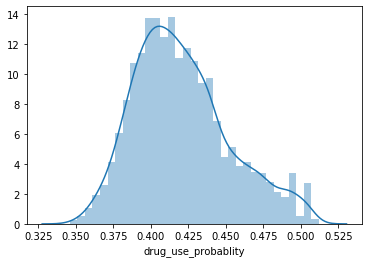

In [21]:
plt.figure()
sns.distplot(scraped_tweets["drug_use_probablity"])